# Exploratory data analysis 

Goal of project: Predict the number of citations an academic paper will get given the title, year it was published, general topic, who submitted the paper, journal it was published, institutions involved, and abstract. 

Information about the paper was taken from https://www.kaggle.com/Cornell-University/arxiv. Of these, ~600k papers were also published in academic journals. The number of times each paper was cited was taken from google scholar.

Thus far, a basic analysis of the data has been done to give a sense of the distribution of citations. A script was written to convert the words in the title of the paper, published and topic into a bag of words model using one hot encoding. An attempt to use xgboost to predict the citations resulted in most predicitions being the mean of the data set, meaning more factors, or more predictive factors, may be needed.

Future work will be done to add more features to the input data for an ML model. The journal the paper is published isn't in the current dataset, this is likely an important variable to add. Information on which univeristies or institutions were invloved in the paper was also found while getting the citation number, and can be cleaned and included. The abstract of each paper contains a large amount of information in text form, and methods such as word vectors of the abstract can be used as inputs to a model.

This notebook shows some of the premliminary data analysis. Scripts used to mine and organize the data are in this repository as .py files. In order to scrape all the citations, the input data set (from kaggle) was divided into sections for parallel scraping. only a few of these folders are present in the repository.

This notebook loads a dataframe and several pickled python variables which were output by the scripts used to process the kaggle dataset and scrapped data. These are the starting point for the analysis shown here

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle as pckl
import os
from rawDataToBagOfWords_oneHotEncode import *  ### some functions located in other scripts are used
from modellingWith_xgboost import * ### some functions located in other scripts are used


In [4]:
#### loading a df from several .csv files
dfList = []
folder = 'dataframe for notebook/'

for file in os.listdir(folder):
    dfList.append(pd.read_csv(str(folder + file),dtype={'ids': object}))


df = pd.DataFrame()

for i,frame in enumerate(dfList):

    #print(frame.head())
    df= pd.concat([df,frame])

In [5]:
df = df.drop(labels = ['Unnamed: 0','Unnamed: 0.1'],axis = 1)

In [9]:
df.head()

,ids,title,journal reference,cited,year,submitting author,category
0,704.0135,A Single Trapped Ion as a Time-Dependent Harmo...,"Phys. Rev. A 76, 052105 (2007)",26,2007,Nicolas Menicucci,quant-ph
1,704.0137,"Topological defects, geometric phases, and the...",Optik-International Journal for Light and Elec...,1,2009,Suresh Tiwari dr,quant-ph
2,704.0138,Circular and non-circular nearly horizon-skimm...,"Phys.Rev.D76:044007,2007",18,2007,Enrico Barausse,gr-qc astro-ph
3,704.0139,The Blue Straggler Population of the Globular ...,"Astrophys.J.663:267-276,2007",79,2007,Barbara Lanzoni,astro-ph
4,704.014,Entanglement entropy of two-dimensional Anti-d...,"Phys.Lett.B653:434-438,2007",31,2007,Mariano Cadoni,hep-th


In [10]:
df.describe()

,cited,year
count,578667.000000,578667.000000
mean,343.110922,2010.382572
std,2102.080560,6.859902
min,1.000000,1990.000000
25%,8.000000,2005.000000
50%,23.000000,2011.000000
75%,62.000000,2016.000000
max,126810.000000,2020.000000


Plotting a histogram of citation number per paper. This what a future model will try to predict

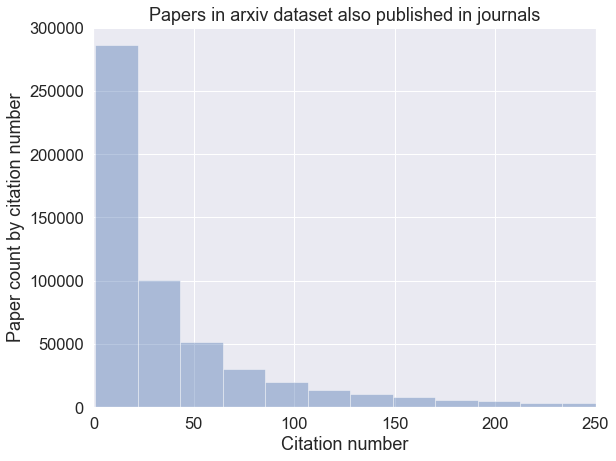

In [12]:
size = (9, 7)
citedDist = sns.distplot(x = df['cited'],bins = 6000, kde = False) #######
citedDist.set(xlim = (0,250))
citedDist.set_title(label = 'Papers in arxiv dataset also published in journals')        
citedDist.set(ylabel='Paper count by citation number')
citedDist.set(xlabel='Citation number')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

[(10, 700000)]

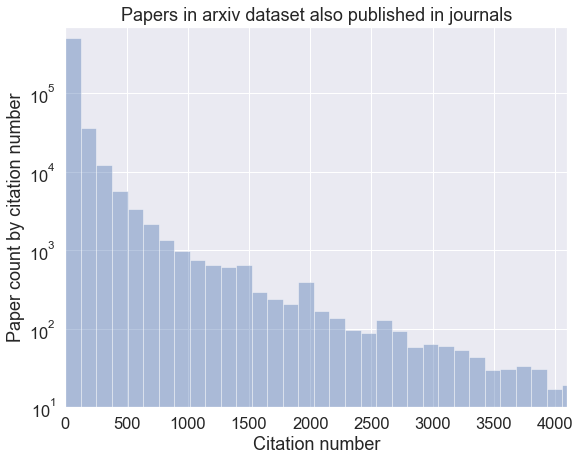

In [13]:
citedDist = sns.distplot(x = df['cited'],bins = 1000, kde = False)
citedDist.set(xlim = (0,4100))
citedDist.set_title(label = 'Papers in arxiv dataset also published in journals')        
citedDist.set(ylabel='Paper count by citation number')
citedDist.set(xlabel='Citation number')
citedDist.set_yscale("log")
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)
citedDist.set(ylim = (10,700000))

Since there a few number of papers have a large number of citations, the histogram should also be viewed on a log scale

Looking at when these papers where published, is a trend in the number of papers published per year (it also looks like more people went to grad school or academia during the recession around 2009)


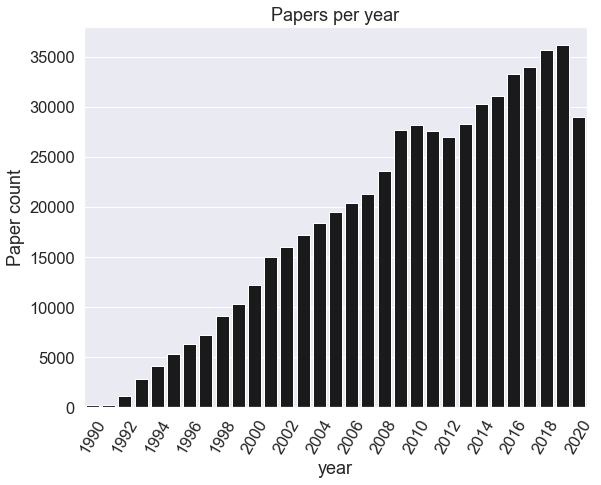

In [14]:
yearDist = sns.countplot(data = df, x = 'year',hue = None,color = 'k')
#yearDist.set(xlim = (0,1000))
plt.xticks(rotation=60)

xticks=yearDist.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
yearDist.set_title(label = 'Papers per year')        
yearDist.set(ylabel='Paper count')
yearDist.set(xlabel='year')

sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)
#change_width(yearDist, .5)

Since there's an increase in academic publishing (or at least in the corners of academia who use the Cornell archives) it would sense that papers published in later years get more citations per year (total citations/years since publication)

In [15]:
df['citedPerYear'] =df['cited']/(2021 - df['year'])

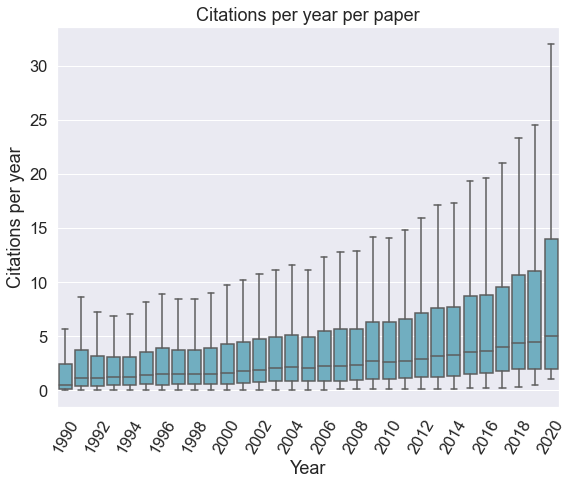

In [16]:
###### this is very slow to run
boxes = sns.boxplot(data = df,x = 'year',y = 'citedPerYear',showfliers=False,\
                    hue = None, color = 'c')

plt.xticks(rotation=60)

xticks=boxes.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)

boxes.set_title(label = 'Citations per year per paper')        
boxes.set(ylabel='Citations per year')
boxes.set(xlabel='Year')
plt.show()

It does seem that more recent papers are being cited more highly

# Setting up inputs to an ML model

The initial attempt to fit an ML model involved converting the title, submitting author, year, and categories into a bag of words using one hot encoding. Spacy was used to extract the lemma from the title, and the other information was added afterwords. Most of the nonsense words and words which appeared infrequently were removed. An issue which has yet to be resolved is that spacy doesn't correctly lemmatize all the science words (antiferromagnetism vs antiferromagnetic)

This was used to construct a sparse matrix for input into an ML model. Some analysis on how many factors are used for each paper, and the number of connections (how many other papers a given paper shares it's words with) are shown below. Contructing and analyzing the bag of words and is done in rawDataToBagOfWords_oneHotEncode.py not this notebook


#### Loading data corresponding to the bag of words

In [20]:
# preProcessingOut 2-8_write
X,y,inputs,names = loadInputData()
#dictMain = inputs[1]
dictBow = inputs[0]
# plotTokCnt(dictBow)
dictMainParts = inputs[1:5]

dictMain = {}

for dic in dictMainParts:
    dictMain.update(dic)

bowVecSpares.npz
dicBow.pckl
dictMain1.pckl
dictMain2.pckl
dictMain3.pckl
dictMain4.pckl
label.pckl
loaded inputs
changed to np arrays


In [21]:
len(dictMain) #### should be ~579k

578668

making df from the dictionary containing the paper id, how many times it was cited, and how many factors are used in the current model

In [22]:
# this cell is slow to run
dfBow = pd.DataFrame(dictMain)
dfBow = dfBow.transpose()
dfBow['ids'] = dfBow.index


In [23]:
colDict = {0:'cited',1:'all_factors',2:'num_factors_used'}
dfBow = dfBow.rename(columns = colDict)
dfBow.columns


Index(['cited', 'all_factors', 'num_factors_used', 'ids'], dtype='object')

In [24]:
dfBow['num_factors_used'] = dfBow['num_factors_used'].astype(int)

looking at the number of factors per paper to be used in the model. This is number of word words left in the bag of words after removing nonsense and words with only ~3 occurances. 

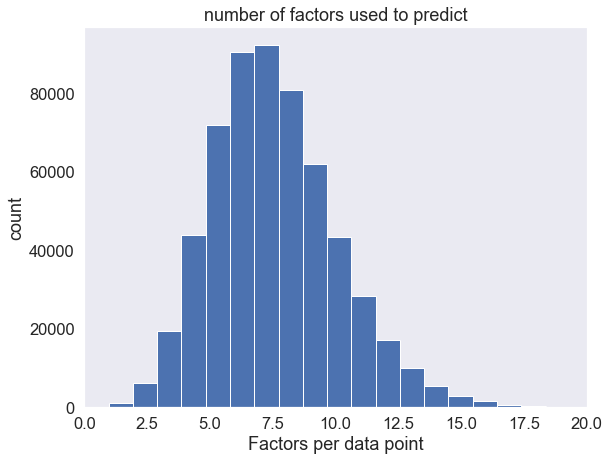

In [25]:
ax2 = dfBow['num_factors_used'].hist(bins = 30,grid = False)

ax2.set(xlim = (0,20))
ax2.set_title(label = 'number of factors used to predict')        
ax2.set(ylabel='count')
ax2.set(xlabel='Factors per data point')
plt.show()

skewed distribution showing that most papers have ~7 words (or factors) this isn't suprising given that the titles have similar length, and each paper will have at least a year and a category

#### Another way to look at the input data is by how many other papers a paper is connected to through the above factors. 
This was done by calcuating the number of unique connections in graph (the papers are nodes and two papers may share more than one factor, or have more than one edge/connection). For a sparse matrix of 500k by 18k, this was very slow and the code isn't shown here. The result is loaded from the file conVec4DataProcessed2-8.pckl


In [26]:
import pickle as pckl
import os
#path = os.getcwd() + '/' + 'preProcessingOut 2-8' +'/'
#file = path + 'conVec4DataProcessed2-8.pckl'
file = 'conVec4DataProcessed2-8.pckl'
with open(file,'rb') as f:
    conVec = pckl.load(f)

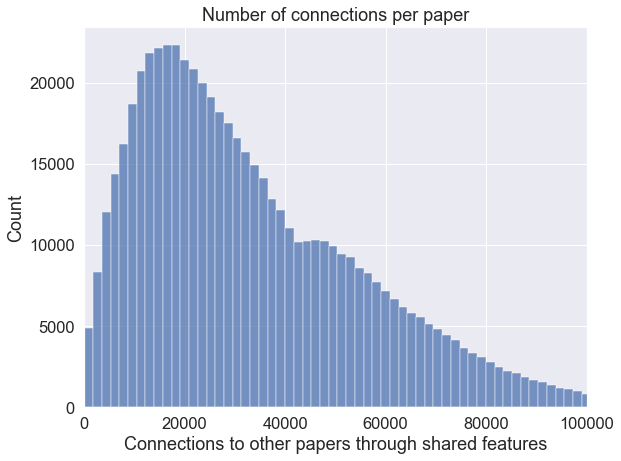

In [27]:
size = (9, 7)
citedDist = sns.histplot(x = conVec,bins = 100, kde = False) #######
citedDist.set(xlim = (0,100000))
citedDist.set_title(label = 'Number of connections per paper')        
citedDist.set(ylabel='Count')
citedDist.set(xlabel='Connections to other papers through shared features')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

Most of the papers have tens of thousands of connections, and there may a grouping which is more highly connected

A first pass at predicting the citation number is shown next. 

This attempt predict the citations resulted in most predicitions being the mean of the data set, meaning more factors, or more predictive factors, may be needed.

In [28]:
#X,y where loaded previously, these are the scipy sparse matrix (X) and the labels (y)
## the functions used here are defined in modellingWith_xgboost
citedList = getListCitedBy(dictMain)
Xm_train,Xm_test,ym_train,ym_test,keys_train,keys_test,cited_train,cited_test\
    = manTTS(dictMain,X,y,citedList) ### doing the train test split manually so its easier to keep track of the the ID of 
#each, the predictions can be loaded back into a dataframe. 

data_dmatrix = xgb.DMatrix(data=Xm_train,label=ym_train) ### loading into xgboost format



In [29]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 20, 'alpha': 10}

Looking at the error when trained with k fold crossvalidation

In [30]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

    

In [31]:
print(cv_results.tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
99      1477.180542       11.552956     1831.865275      26.090529


In [32]:
### training again 
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

In [33]:
data_dmatrix_Xm_test = xgb.DMatrix(data=Xm_test)
preds = xg_reg.predict(data_dmatrix_Xm_test)

C:\Users\bcyk5\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 500.0)]

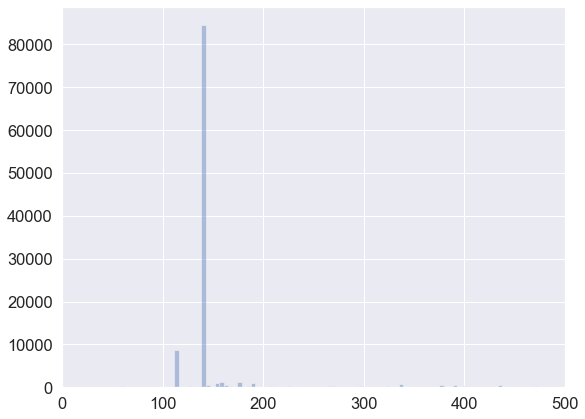

In [34]:
ax = sns.distplot(x = preds,bins = 5000, kde = False)
ax.set(xlim = (0,500))

Expect for a few cases, the model predicts the same number of citations for each paper. 

## Feature engineeering and future work

Portions of html were saved when the citations were scrapped. This html contains additional information which has not yet been mined. An example is shown below, from the paper "High energy neutrinos from neutralino annihilations in the Sun". 

The Univiersities and Departments represeneted by the authors are listed, as is the full name of the journal. Insitutions which are well regarded and well connected are typically more highly cited, as are publications in the more prestigous journals

#### The next step in this project is include faetures which may be more predictive, and add more models, such as a keras deep learning network, to the pipeline. The quality of the predicitions will be checked as more features are added